# **A full 1D analysis using the low-level Gammapy API**

**Objective: Performing a full spectral anaysis of the point source [PKS 2155-304](http://tevcat.uchicago.edu/?mode=1&showsrc=90)**

Here we demonstrate the data reduction and spectral fitting for a point like source, using the [reflected regions background estimation](https://docs.gammapy.org/1.1/user-guide/makers/reflected.html?highlight=reflected) method.

In practice, we have to:
- Prepare the **data access and selection**
  - Create a `~gammapy.data.DataStore` poiting to the relevant data 
  - Apply an observation selection to produce a list of observations, a `~gammapy.data.Observations` object.
- Set up the **analyis parameters**
  - Define the [reconstructed energy](https://docs.gammapy.org/1.2/user-guide/references.html#term-Reco-Energy) axis and [true energy](https://docs.gammapy.org/1.2/user-guide/references.html#term-True-Energy) axis using the `~gammapy.maps.MapAxis` object
  - Define the spatial geometry
  - Define the [exclusion mask](https://docs.gammapy.org/1.2/tutorials/api/mask_maps.html)
  - Choose the correct `~gammapy.datasets.Dataset` type and define it
- Do the **data reduction**
  - Create the necessary makers : 
    - the spectrum dataset maker : `~gammapy.makers.SpectrumDatasetMaker`
    - the reflected regions finder: either `~gammapy.makers.ReflectedRegionsFinder` or `~gammapy.makers.WobbleRegionsFinder`
    - the background maker, here a `~gammapy.makers.ReflectedRegionsBackgroundMaker`
    - and usually the safe range maker : `~gammapy.makers.SafeMaskMaker`
  - Perform the data reduction loop. And for every observation:
    - Apply the makers sequentially to produce the current `~gammapy.datasets.SpectrumDatasetOnOff`
    - Stack it on the target one.
- Make **the modeling and fitting**
  - Define the `~gammapy.modeling.models.SkyModel` to fit the data. Being this a spectral analysis, the `SkyModel` is completely defined by a  `~gammapy.modeling.models.SpectralModel` (no spatial information is required)
  - Create a `~gammapy.modeling.Fit` object and run it to fit the model parameters
  - Apply a `~gammapy.estimators.FluxPointsEstimator` to compute flux points for the spectral part of the fit.

## Setup
First, we setup the analysis by performing required imports.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import logging
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from gammapy.maps import WcsGeom, MapAxis, RegionGeom
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
    LogParabolaSpectralModel,
    EBLAbsorptionNormSpectralModel
)
from gammapy.makers import SafeMaskMaker, SpectrumDatasetMaker, ReflectedRegionsFinder, ReflectedRegionsBackgroundMaker
from gammapy.modeling import Fit
from gammapy.datasets import MapDataset, FluxPointsDataset, Datasets, SpectrumDataset
from scipy.stats import chi2
from gammapy.stats.utils import ts_to_sigma
from gammapy.catalog import SourceCatalog4FGL

from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.estimators import FluxPointsEstimator
from gammapy.data import DataStore
from gammapy.visualization import plot_spectrum_datasets_off_regions

In [2]:
from gammapy.utils.check import check_tutorials_setup
check_tutorials_setup()


System:

	python_executable      : /home/khelifi/mambaforge/envs/gammapy-1.1/bin/python 
	python_version         : 3.9.18     
	machine                : x86_64     
	system                 : Linux      


Gammapy package:

	version                : 1.1        
	path                   : /home/khelifi/mambaforge/envs/gammapy-1.1/lib/python3.9/site-packages/gammapy 


Other packages:

	numpy                  : 1.24.4     
	scipy                  : 1.10.1     
	astropy                : 5.3.4      
	regions                : 0.7        
	click                  : 8.1.3      
	yaml                   : 6.0.1      
	IPython                : 8.7.0      
	jupyterlab             : 3.5.3      
	matplotlib             : 3.7.3      
	pandas                 : 1.5.2      
	healpy                 : 1.16.6     
	iminuit                : 2.21.3     
	sherpa                 : 4.15.1     
	naima                  : 0.10.0     
	emcee                  : 3.1.3      
	corner                 : 2.2.1      
	ray  

## Very optional set-up

The documentation contains also tricks for the users: see the [HowTo](https://docs.gammapy.org/1.1/user-guide/howto.html) section, use search bar, ...

**The logging level**

In [3]:
logging.basicConfig()    
log = logging.getLogger("1Danalysis")
log.setLevel(logging.WARNING) #INFO, WARNING, DEBUG

**Suppression of the astropy warnings**

In [4]:
# from astropy.io.fits.verify import VerifyWarning
# import warnings

# with warnings.catch_warnings():
#     warnings.simplefilter('ignore', VerifyWarning)

**Progress bar**

In [5]:
# If the external library `tqdm` is installed
from gammapy.utils import pbar
pbar.SHOW_PROGRESS_BAR = True

## Defining the datastore and selecting observations

We first use the `~gammapy.data.DataStore` object to access the observations we want to analyse, here the [H.E.S.S. DL3 DR1](https://www.mpi-hd.mpg.de/HESS/pages/dl3-dr1/) (data release 1). 

In [6]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")

In [7]:
pos = SkyCoord(329.71693844, -30.22558846, unit=u.deg, frame="icrs")
pos.icrs

<SkyCoord (ICRS): (ra, dec) in deg
    (329.71693844, -30.22558846)>

We can now define an observation filter to select only the relevant observations. 
Here we use a cone search that we define with a python dict.

We then filter the `ObservationTable` with `~gammapy.data.ObservationTable.select_sky_circle()`.

In [8]:
obs_table_filtered = data_store.obs_table.select_sky_circle(center=pos, radius=2 * u.deg)
obs_ids = obs_table_filtered["OBS_ID"]

If you wish to apply more complex filtering options, you can use the `~gammapy.data.ObservationTable.select_observations()` method instead. This provides the freedom of selecting observations based on a sky circle, time period or parameter (e.g. Zenith angle) range.

We can now retrieve the relevant observations by passing their `obs_id` to the`~gammapy.data.DataStore.get_observations()` method.

In [9]:
observations = data_store.get_observations(obs_ids)
print(f"Number of selected observations : {len(observations)}")

INFO:gammapy.data.data_store:Observations selected: 21 out of 21.


Number of selected observations : 21


We restrict the analysis to the [July 2006 flaring event](https://ui.adsabs.harvard.edu/abs/2009A%26A...502..749A/abstract) using `gammapy.data.Observations.select_time()`.

In [10]:
time_interval = Time(
    ["2006-07-29T20:30", "2006-07-30T20:30"]
)

In [11]:
observations = observations.select_time(time_interval)
print(observations[5])

Observation

	obs id            : 33792 
 	tstart            : 53945.96
	tstop             : 53945.98
	duration          : 1688.00 s
	pointing (icrs)   : 329.1 deg, -30.2 deg

	deadtime fraction : 7.4%



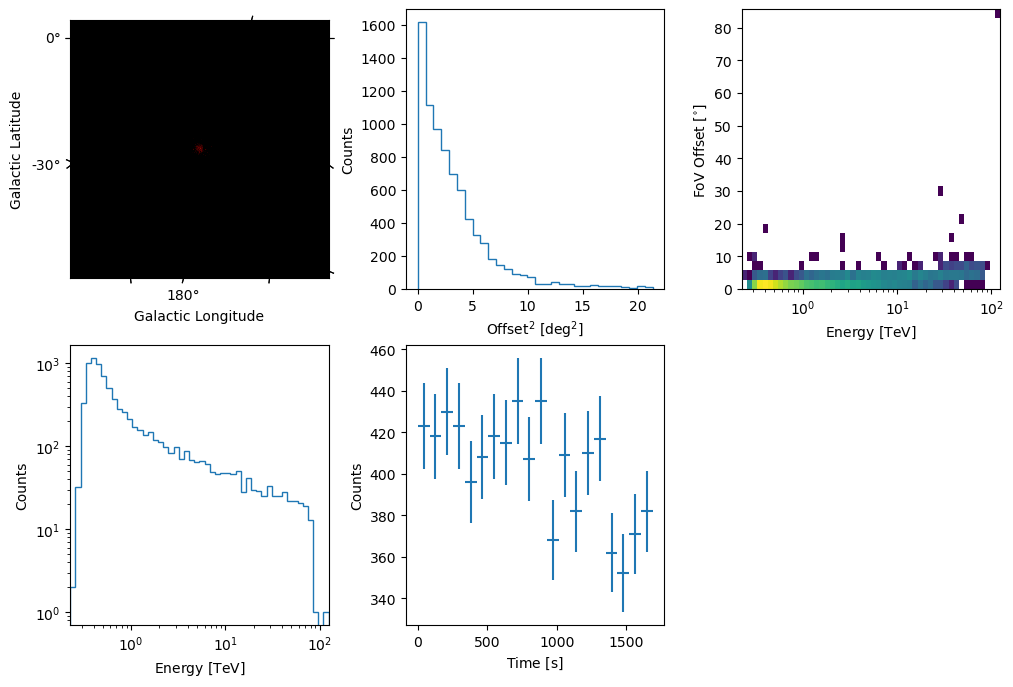

In [12]:
obs = observations[12]
obs.events.peek()

/home/khelifi/mambaforge/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


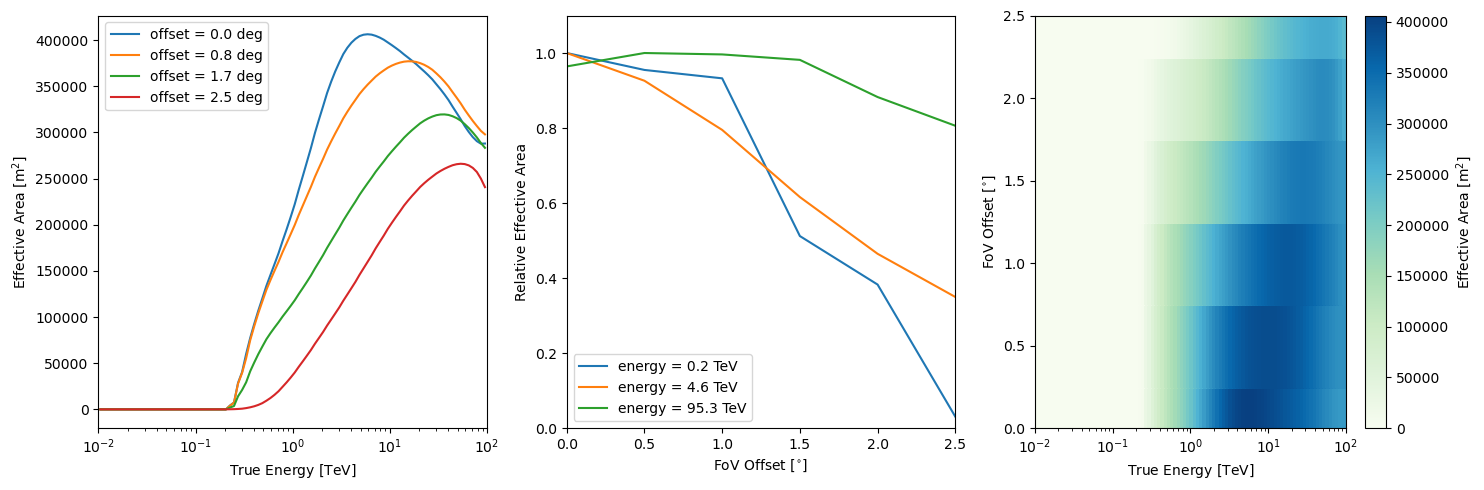

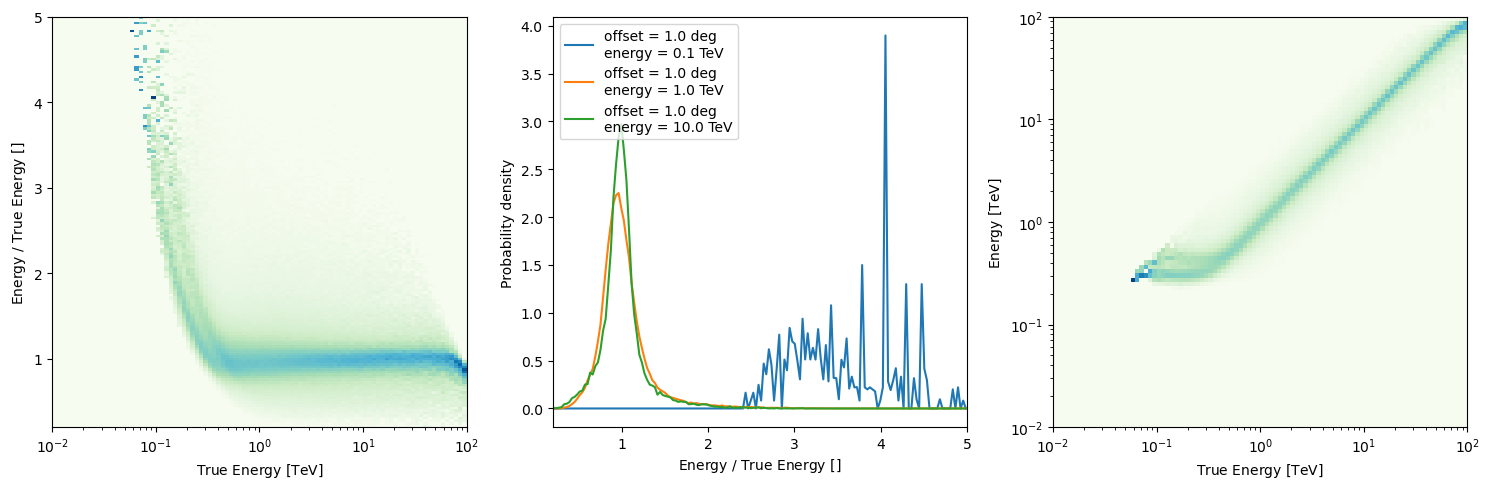

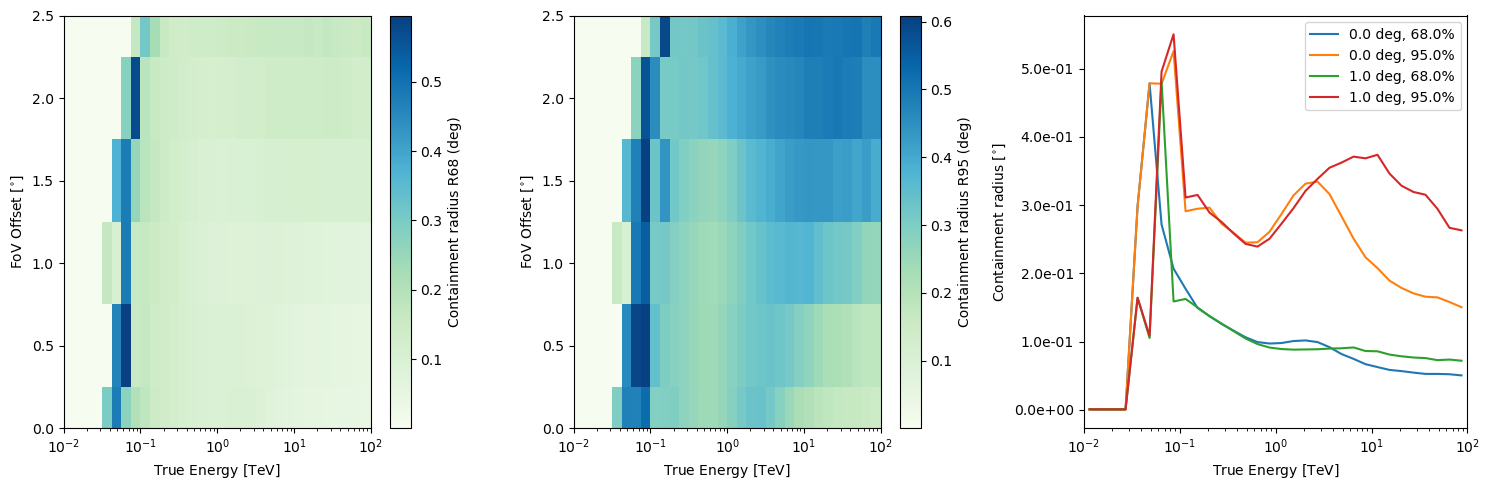

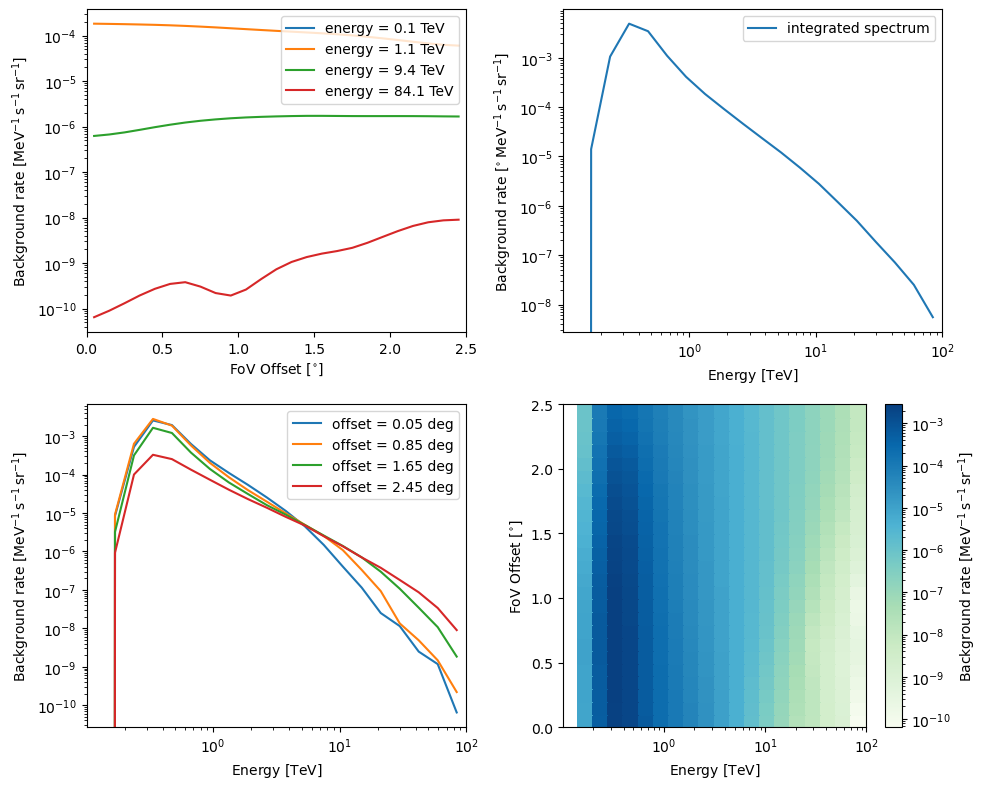

In [13]:
obs.aeff.peek();
obs.edisp.peek();
obs.psf.peek();
obs.bkg.peek();

## Preparing reduced datasets geometry

Now we define the [reconstructed](https://docs.gammapy.org/1.1/user-guide/references.html#term-Reco-Energy) and [true](https://docs.gammapy.org/1.1/user-guide/references.html#term-True-Energy) energy axes: 

In [14]:
energy_axis = MapAxis.from_energy_bounds(
    0.1, 40, nbin=10, per_decade=True, unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    0.05, 100, nbin=20, per_decade=True, unit="TeV", name="energy_true"
)

**PS**: Note the energy ranges between the reconstructed and true energy band!

We then define a ON region to extract the spectrum, and create the analysis geometry using the `RegionGeom` object:

In [15]:
on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pos, radius=on_region_radius)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])

Now we can define the dataset used for this 1D analysis using this geometry.

In [16]:
dataset_empty = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_axis_true
)

## Create exclusion mask

To perform the spectral analysis we must mask all the gamma ray emission in the analysis region, which would otherwise bias the background estimation. Here we are analyzing an extra-Galactic source, which is isolated and would not require a priori an exclusion mask. However, for illustration purpose, we choose a mask of 0.5 deg to the North of the blazar.

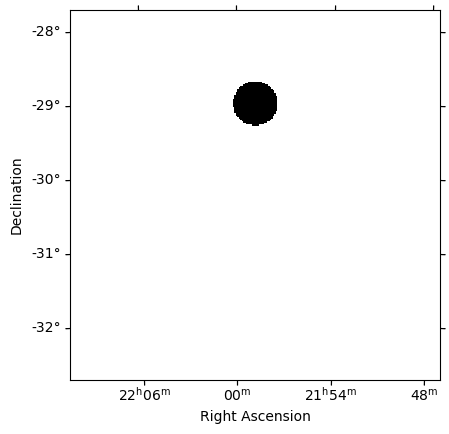

In [17]:
exclusion_region = CircleSkyRegion(
    center=SkyCoord(329.71, -29, unit="deg", frame="icrs"),
    radius=0.3 * u.deg,
)

skydir = pos.icrs
exgeom = WcsGeom.create(width=5*u.deg, binsz=0.02, skydir=skydir, proj="TAN", frame="icrs"
)

exclusion_mask = ~exgeom.region_mask([exclusion_region])
exclusion_mask.plot();

## Data reduction

### Create the maker classes to be used
We first initialize the `Maker` objects that will take care of the data reduction.

The `~gammapy.makers.SpectrumDatasetMaker`creates a `SpectrumDataset` for each observation.

In [18]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)

**PS: zoom on the parameter `containment_correction'**

>In the used data release, the IRFs are computed for a "full containment" response, ie all the signal for an objet falls into the analysis Region of Interest (there is no PSF leakage).
>
>However, here for the 1D analysis with a `RegionGeom' of 0.11 deg, a part of the signal lies outside the selection region. Then, the IRFs, and mainly the collection area, should be corrected from the PSF leakage.
>
>If a data release is made with point-source IRFs, have a look in [this tutorial](https://docs.gammapy.org/dev/tutorials/analysis-1d/spectral_analysis_rad_max.html).
>

The `~gammapy.makers.ReflectedRegionsBackgroundMaker` appends a background estimate (based on the [reflected regions](https://docs.gammapy.org/1.0.1/user-guide/makers/reflected.html?highlight=reflected) method) to an input `SpectrumDataset`, converting it into a `SpectrumDatasetOnOff`.

In [19]:
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)

By default the `ReflectedRegionsBackgroundMaker` defines the OFF regions by rotating the ON region around the pointing position.

PS: if you need to apply more complex criteria to your OFF regions selection (e.g. an energy dependent rad-max cut / configure the number of OFF regions, etc) you can additionally pass to the `ReflectedRegionsBackgroundMaker` an instance of `~gammapy.makers.WobbleRegionsFinder` (see [this tutorial](https://docs.gammapy.org/1.1/user-guide/makers/reflected.html) or [this one](https://docs.gammapy.org/1.1/tutorials/analysis-1d/spectral_analysis_rad_max.html)).

Finally we define a `~gammapy.makers.SafeMaskMaker` instance, which is responsible of selecting the safe data range (in energy and space) in which the data can be used.
In this example we only use the method `aeff-default`, which reads the safe energy threshold specified in the DL3 FITS files. For other available method see the documentation of the [SafeMaskMaker](https://docs.gammapy.org/1.1/api/gammapy.makers.SafeMaskMaker.html?highlight=safemaskmaker)

In [20]:
safe_mask_masker = SafeMaskMaker(methods=["aeff-default"])
# safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

### Perform the data reduction loop

For the moment the datasets are not stacked, but appended into a `Datasets` object (that basically contains a list of datasets). That's because we want to produce diagnostic plots such as the cumulative source significance as a function of the observation livetime. The stacking will be performed later on. 

In [21]:
%%time

datasets = Datasets()
for observation in observations:
    # First a spectrum dataset with the same geometry as the reference empty one is filled with 
    # the data and IRFs
    dataset = dataset_maker.run(dataset_empty.copy(name=str(observation.obs_id)), observation)
    # Reflected regions background estimation
    dataset_on_off = bkg_maker.run(dataset, observation)
    # The data quality cut is applied
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    # The resulting dataset is appended to the list
    datasets.append(dataset_on_off)

CPU times: user 10 s, sys: 94 ms, total: 10.1 s
Wall time: 10.1 s


/home/khelifi/mambaforge/envs/gammapy-1.1/lib/python3.9/site-packages/regions/shapes/circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


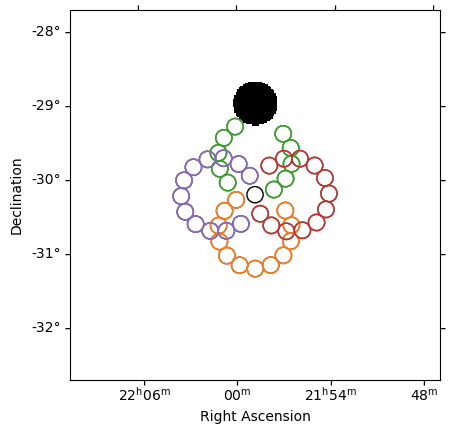

In [22]:
ax = exclusion_mask.plot();
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets);
on_region.to_pixel(ax.wcs).plot(ax=ax, color="black");

In [23]:
info_table = datasets.info_table(cumulative=True)
# info_table
# info_table[:5]
# display(info_table)
info_table.show_in_notebook()

idx,name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
0,stacked,71,63.0,12.122584261154099,8.0,13.727272907071862,13.727272907071862,nan,2376553.25,757184192.0,1327.2796225799502,1361.99999983087,0.05349287278440322,0.006027365947538391,0.04746550683686483,27,16,wstat,169.28689704747893,80,16.0,160.0,0.10000000149011612
1,stacked,488,470.5833435058594,40.66038436691936,17.41666603088379,55.71942576033878,55.71942576033878,nan,3549789.5,1404603136.0,2923.3814141554967,3050.9999998308654,0.16692997965883727,0.005957712512828265,0.16097227040823922,27,18,wstat,1736.5046353203427,193,18.0,199.46412658691406,0.09024178981781006
2,stacked,1300,1271.8333740234375,70.64047870568639,28.166667938232422,128.8394278866007,128.8394278866007,nan,38543.67578125,1937632000.0,4506.825003515018,4738.999999830864,0.2884514040341234,0.006249780702881592,0.28220163264193615,27,19,wstat,5179.282343355091,322,19.0,217.20709228515625,0.08747412264347076
3,stacked,2185,2145.75,93.37163480893057,39.25,207.47504489504564,207.47504489504564,nan,163008.84375,2368244480.0,6068.20214156343,6428.999999830866,0.3600737004184653,0.006468143131086848,0.35360555728737847,27,20,wstat,8937.464285699089,455,20.0,231.8471221923828,0.0862637385725975
4,stacked,3137,3087.14990234375,112.55658311025535,49.84999465942383,301.2646412066846,301.2646412066846,nan,511080.0,2737153792.0,7636.079726788242,8117.99999983087,0.41081289251015085,0.006528218201355906,0.4042846608206139,27,21,wstat,12875.774571416583,561,21.0,236.32901000976562,0.08885917067527771
5,stacked,3911,3852.14990234375,126.3999008151743,58.84999465942383,368.8798856082214,368.8798856082214,nan,3783955.25,3059316992.0,9198.43884948178,9805.999999830869,0.4251808447060924,0.0063978241984768225,0.41878300931040835,27,21,wstat,16209.656644575942,669,21.0,238.72560119628906,0.08796710520982742
6,stacked,4609,4535.89990234375,136.86220796301126,73.0999984741211,434.72465921607017,434.72465921607017,nan,12817896.0,3360839936.0,10765.1096513374,11494.999999830863,0.42814241092541055,0.006790455540324157,0.42135194617179156,27,22,wstat,18966.385982689502,840,22.0,252.80438232421875,0.08702380955219269
7,stacked,5338,5253.64990234375,147.4559809468099,84.3499984741211,500.9607443052237,500.9607443052237,nan,24941528.0,3652919552.0,12329.822518716592,13182.999999830867,0.43293405009658087,0.006841136467785999,0.4260929055847108,27,22,wstat,21995.449530989583,975,22.0,254.29757690429688,0.08651281893253326
8,stacked,6014,5917.0498046875,155.86949379389455,96.94999694824219,574.5003242236328,574.5003242236328,nan,36121280.0,3955045120.0,13892.848960134226,14871.999999830867,0.4328845737297856,0.006978410060200172,0.42590614939142996,27,22,wstat,24544.84437240788,1101,22.0,249.8401336669922,0.08805631101131439


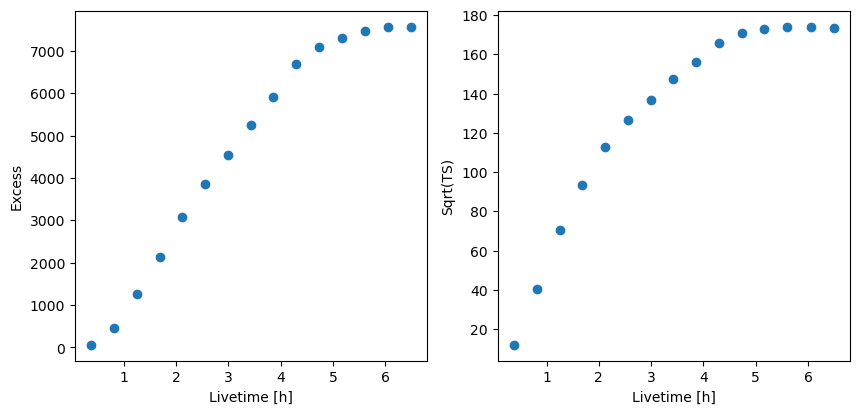

In [24]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221)
ax1.plot(
    info_table["livetime"].to("h"), info_table["excess"], marker="o", ls="none"
)
ax1.set_xlabel("Livetime [h]")
ax1.set_ylabel("Excess");


ax2 = plt.subplot(222)
ax2.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)
ax2.set_xlabel("Livetime [h]")
ax2.set_ylabel("Sqrt(TS)");


Save the dataset to disc using `~gammapy.datasets.Datasets.write()` method.

PS: The OGIP format is used (PHA, ARF, RMF, BKG, [see](https://gamma-astro-data-formats.readthedocs.io/en/latest/spectra/ogip/index.html) here for details)

In [25]:
filename = "pks-joint-dataset.yaml"
datasets.write(filename, overwrite=True)

In [26]:
#! cat pks-joint-dataset.yaml

Before fitting we stack the `Datasets` into a single `SpectrumDatasetOnOff`:

In [27]:
#create stacked
stacked = datasets.stack_reduce()

In [28]:
print(stacked)

SpectrumDatasetOnOff
--------------------

  Name                            : N_1CVmK- 

  Total counts                    : 7724 
  Total background counts         : 154.55
  Total excess counts             : 7569.45

  Predicted counts                : 761.57
  Predicted background counts     : 761.57
  Predicted excess counts         : nan

  Exposure min                    : 4.60e+07 m2 s
  Exposure max                    : 6.86e+09 m2 s

  Number of total bins            : 27 
  Number of fit bins              : 22 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 30569.23

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 1772 
  Acceptance                      : 27 
  Acceptance off                  : 309 



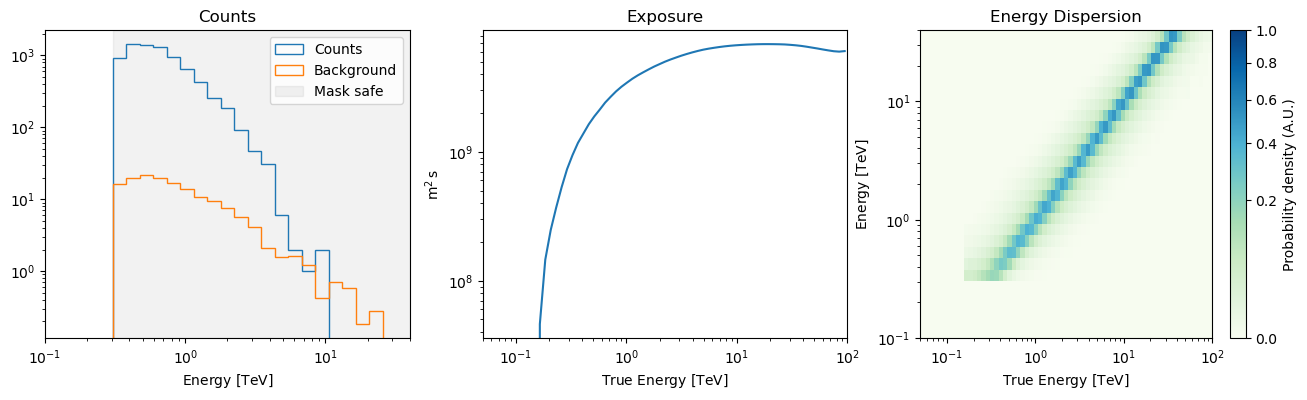

In [29]:
stacked.peek()

## Data Fitting

In this section we fit a spectral model to the data. We can try to answer the following questions:
- What is the significance of the detected source?
- What is the best spectral shape to describe the spectrum of the source? 

In particular, we can use the [likelihood ratio test](https://docs.gammapy.org/1.1/user-guide/stats/index.html#estimating-ts) (see also the associated HowTo) to compare three different hypotheses:
- H0: Background only (no source)
- H1: Background + source described by a power law model
- H2: Background + source described by a power law model with exponential cutoff

### **H0**

The value of the quantity $-2\ln\mathcal(L)$ for the background-only model (null hypothesis) can be simply computed as

In [30]:
Wstat_0 = stacked.stat_sum()
print(Wstat_0)

30569.227611047037


Since the background has been estimated using the reflected regions method, here $-2\ln\mathcal(L)$ corresponds to the so-called [Wstat](https://docs.gammapy.org/0.20/userguide/references.html#term-WStat) fit statistic.

We can inspect the model residuals for the H0 hypothesis:

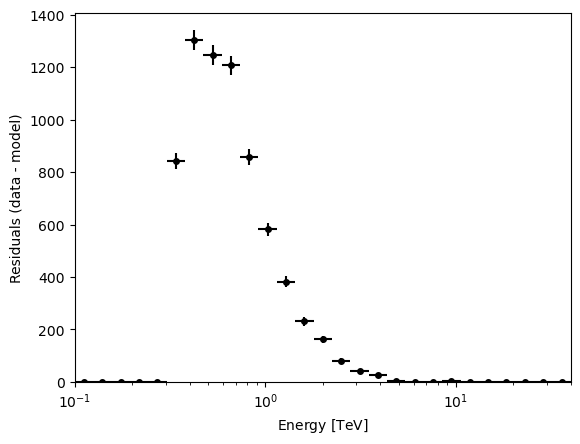

In [31]:
stacked.plot_residuals_spectral();

As expected, the residuals show a clear positive feature indicating that a source is missing in the model. 

## **H1**
We now add a source defined by a power law spectrum to the model.

Here we also consider [EBL absorption](https://docs.gammapy.org/1.1/user-guide/model-gallery/spectral/plot_absorbed.html?highlight=ebl). To get the list of EBL models, you can type:

In [32]:
# import gammapy.modeling.models.spectral as spectral
# spectral.EBL_DATA_BUILTIN

In [33]:
spectral_model_pl = PowerLawSpectralModel()
redshift = 0.116
ebl = EBLAbsorptionNormSpectralModel.read_builtin("finke", redshift=redshift)
spectral_model_1 = spectral_model_pl * ebl

pks_model_1 = SkyModel(spectral_model=spectral_model_1,
                    name="pks_model")

In [34]:
pks_model_1.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str10,float64,str14,int64,float64,float64,bool,bool,str1
spectral,index,2.0000e+00,,0.000e+00,nan,nan,False,False,
spectral,amplitude,1.0000e-12,TeV-1 s-1 cm-2,0.000e+00,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spectral,alpha_norm,1.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,redshift,1.1600e-01,,0.000e+00,nan,nan,True,False,


In [35]:
stacked.models = [pks_model_1]

In [36]:
%%time
fit1 = Fit(optimize_opts={"print_level": 1})
result1 = fit1.run(datasets=[stacked])

CPU times: user 439 ms, sys: 2.65 ms, total: 442 ms
Wall time: 444 ms


It is recommanded to get the result status of the minimizer, iMinuit here:

In [37]:
print(result1.success)
# print(result1)
print(result1.minuit)

True
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 151.4                      │              Nfcn = 167              │
│ EDM = 4.25e-10 (Goal: 0.0002)    │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬────────

In [38]:
result1.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str9,str8,str10,float64,str14,float64,float64,float64,bool,bool,str1
pks_model,spectral,index,2.6239e+00,,2.231e-02,nan,nan,False,False,
pks_model,spectral,amplitude,2.8220e-10,TeV-1 s-1 cm-2,4.751e-12,nan,nan,False,True,
pks_model,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
pks_model,spectral,alpha_norm,1.0000e+00,,0.000e+00,nan,nan,True,False,
pks_model,spectral,redshift,1.1600e-01,,0.000e+00,nan,nan,True,False,


In [39]:
Wstat_1 = result1.total_stat
delta_ts = Wstat_0-Wstat_1
df = len(result1.models.parameters.free_parameters.names)
sigma = ts_to_sigma(delta_ts, df=df)
print(f"The delta_ts  of H1 vs H0: {delta_ts:.3f}, that gives a p-value of {chi2.sf(delta_ts, df)}")
print(f"Converting this to a significance gives: {sigma:.3f} \u03C3")

The delta_ts  of H1 vs H0: 30417.864, that gives a p-value of 0.0
Converting this to a significance gives: inf σ


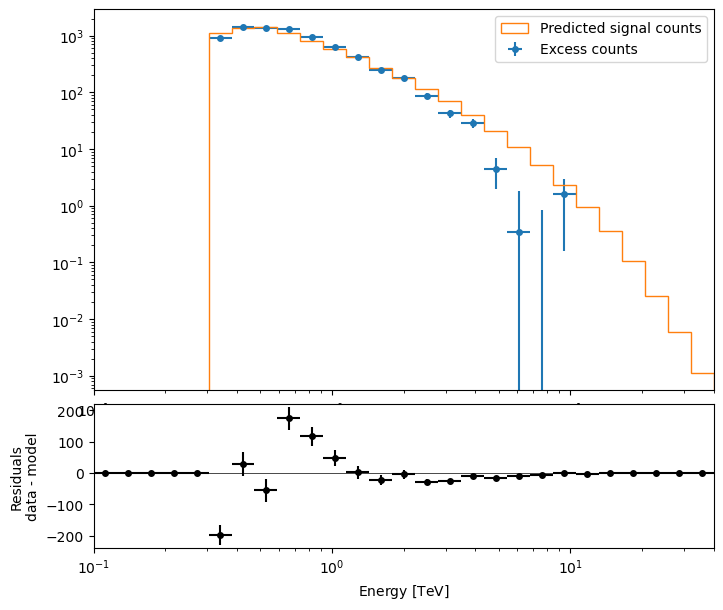

In [40]:
ax_spectrum, ax_residuals = stacked.plot_fit()
# ax_spectrum.set_xlim(0.2, 70)
# stacked.plot_masks(ax=ax_spectrum);

We can compute flux points for the H1 model assumption.

In [41]:
energy_edges = np.logspace(-1, 1.6, 12)*u.TeV
fpe = FluxPointsEstimator(energy_edges=energy_edges, source=pks_model_1.name, selection_optional=["ul"])

In [42]:
%%time
flux_points = fpe.run(datasets=[stacked])

Energy bins:   0%|          | 0/11 [00:00<?, ?it/s]

CPU times: user 1.94 s, sys: 13.5 ms, total: 1.95 s
Wall time: 1.97 s


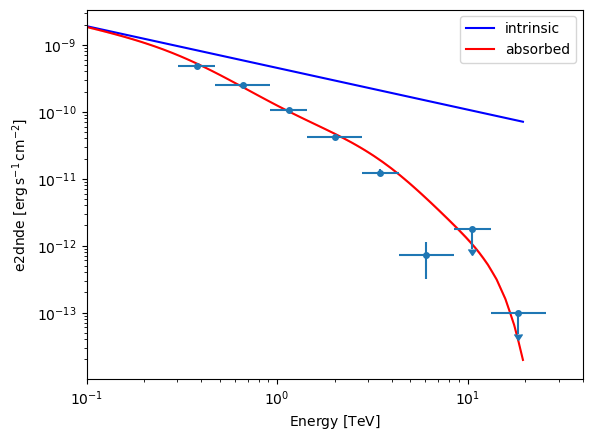

In [43]:
ax = spectral_model_pl.plot(energy_bounds=[0.1,20]*u.TeV, sed_type="e2dnde", label="intrinsic", color="blue")
spectral_model_1.plot(ax=ax, energy_bounds=[0.1,20]*u.TeV, sed_type="e2dnde", label="absorbed", color="red")
spectral_model_1.plot_error(ax=ax, energy_bounds=[0.1,20]*u.TeV, sed_type="e2dnde", facecolor="red")
flux_points.plot(ax=ax, sed_type="e2dnde")
plt.legend();

In [44]:
spectral_model_1.to_dict()

{'spectral': {'type': 'CompoundSpectralModel',
  'model1': {'type': 'PowerLawSpectralModel',
   'parameters': [{'name': 'index',
     'value': 2.6239326059639843,
     'error': 0.02230879405074789},
    {'name': 'amplitude',
     'value': 2.822031559468043e-10,
     'unit': 'TeV-1 s-1 cm-2',
     'error': 4.751168246610097e-12},
    {'name': 'reference', 'value': 1.0, 'unit': 'TeV'}]},
  'model2': {'type': 'EBLAbsorptionNormSpectralModel',
   'parameters': [{'name': 'alpha_norm', 'value': 1.0},
    {'name': 'redshift', 'value': 0.11599999999999999}],
   'filename': '/home/khelifi/MesProgrammes/gammapy-data/ebl/frd_abs.fits.gz'},
  'operator': 'mul'}}

## **H2**

We now estimate the significance for the presence of an exponential cutoff in the source spectrum, again taking into account the EBL absorption.

In [45]:
spectral_model_ecpl = ExpCutoffPowerLawSpectralModel()
redshift = 0.116
spectral_model_2 = spectral_model_ecpl * ebl

pks_model_2 = SkyModel(spectral_model=spectral_model_2,
                    name="pks_model")

In [46]:
pks_model_2.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str10,float64,str14,float64,float64,float64,bool,bool,str1
spectral,index,1.5000e+00,,0.000e+00,nan,nan,False,False,
spectral,amplitude,1.0000e-12,TeV-1 s-1 cm-2,0.000e+00,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spectral,lambda_,1.0000e-01,TeV-1,0.000e+00,nan,nan,False,False,
spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,alpha_norm,1.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,redshift,1.1600e-01,,0.000e+00,nan,nan,True,False,


In [47]:
stacked.models = [pks_model_2]

In [48]:
%%time
fit2 = Fit(optimize_opts={"print_level": 1})
result2 = fit2.run(datasets=[stacked])

/home/khelifi/mambaforge/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/khelifi/mambaforge/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/khelifi/mambaforge/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/khelifi/mambaforge/envs/gammapy-1.1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/khelifi/mambaforge/envs/gammapy-1.1/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow

CPU times: user 1.36 s, sys: 34 µs, total: 1.36 s
Wall time: 1.36 s


In [49]:
result2.success

True

In [50]:
result2.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str9,str8,str10,float64,str14,float64,float64,float64,bool,bool,str1
pks_model,spectral,index,1.8996e+00,,8.460e-02,nan,nan,False,False,
pks_model,spectral,amplitude,7.4490e-10,TeV-1 s-1 cm-2,8.450e-11,nan,nan,False,True,
pks_model,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
pks_model,spectral,lambda_,8.3664e-01,TeV-1,1.013e-01,nan,nan,False,False,
pks_model,spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,False,
pks_model,spectral,alpha_norm,1.0000e+00,,0.000e+00,nan,nan,True,False,
pks_model,spectral,redshift,1.1600e-01,,0.000e+00,nan,nan,True,False,


In [51]:
Wstat_2 = result2.total_stat
delta_ts = Wstat_1-Wstat_2
df = len(result2.models.parameters.free_parameters.names)-len(result1.models.parameters.free_parameters.names)
sigma = ts_to_sigma(delta_ts, df=df)
print(f"The delta_ts  of H2 vs H1: {delta_ts:.3f}, that gives a p-value of {chi2.sf(delta_ts, df)}")
print(f"Converting this to a significance gives: {sigma:.3f} \u03C3")

The delta_ts  of H2 vs H1: 111.873, that gives a p-value of 3.809465564889057e-26
Converting this to a significance gives: 10.577 σ


We have successfully detected a cutoff in the observed spectrum.

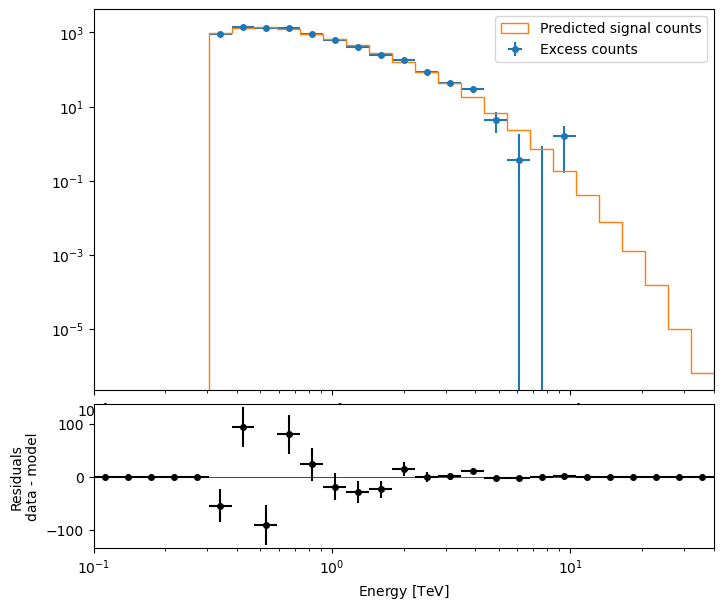

In [52]:
ax_spectrum, ax_residuals = stacked.plot_fit()

To check that the fit has coverged correctly, it is always a good idea to inspect the likelihood profile for the free model parameters.

Scan values:   0%|          | 0/25 [00:00<?, ?it/s]

Scan values:   0%|          | 0/25 [00:00<?, ?it/s]

Scan values:   0%|          | 0/25 [00:00<?, ?it/s]

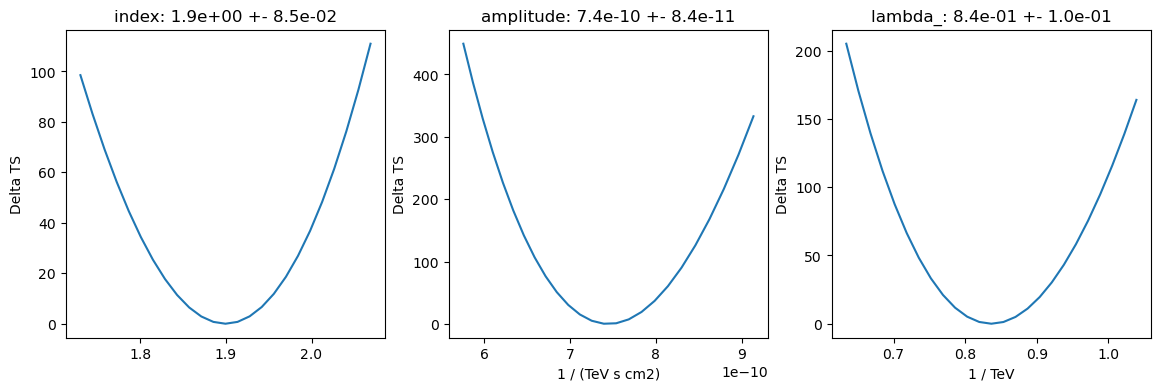

In [53]:
total_stat = result2.total_stat

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

for ax, par in zip(axes, pks_model_2.parameters.free_parameters):
    par.scan_n_values = 25

    profile = fit2.stat_profile(datasets=[stacked], parameter=par)
    ax.plot(profile[f"{pks_model_2.name}.spectral.{par.name}_scan"], profile["stat_scan"] - total_stat)
    ax.set_xlabel(f"{par.unit}")
    ax.set_ylabel("Delta TS")
    ax.set_title(f"{par.name}: {par.value:.1e} +- {par.error:.1e}")

We now compute the flux points for the H2 hypothesis.

In [54]:
%%time
flux_points = fpe.run(datasets=[stacked])

Energy bins:   0%|          | 0/11 [00:00<?, ?it/s]

CPU times: user 2.05 s, sys: 17.6 ms, total: 2.07 s
Wall time: 2.06 s


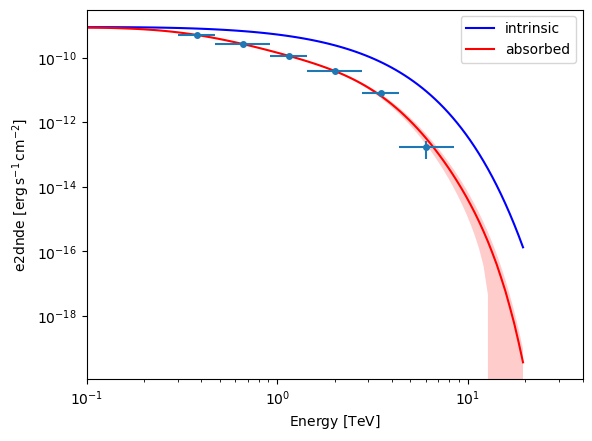

In [55]:
ax = spectral_model_ecpl.plot(energy_bounds=[0.1,20]*u.TeV, sed_type="e2dnde", label="intrinsic", color="blue")
spectral_model_2.plot(ax=ax, energy_bounds=[0.1,20]*u.TeV, sed_type="e2dnde", label="absorbed", color="red")
spectral_model_2.plot_error(ax=ax, energy_bounds=[0.1,20]*u.TeV, sed_type="e2dnde", facecolor="red")
flux_points.plot(ax=ax, sed_type="e2dnde")
plt.legend();

In [56]:
flux_points.to_table()

e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,norm_ul,ts,sqrt_ts,npred,npred_excess,stat,is_ul,counts,success
TeV,TeV,TeV,1 / (TeV s cm2),1 / (s cm2),TeV / (s cm2),,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,bool,float64[1],bool
0.12484541354466076,0.10000000000000002,0.1558637728313736,3.3332816846204594e-08,1.8601432686499983e-09,2.29886484898109e-10,nan,nan,nan,nan,nan,nan,0.0,0.0,False,0.0,False
0.21742229366110305,0.1558637728313736,0.3032934011676863,9.551279166829128e-09,1.4151401678475216e-09,2.974503595593698e-10,nan,nan,nan,nan,nan,nan,0.0,0.0,False,0.0,False
0.37864790094146483,0.3032934011676863,0.47272453780854895,2.176624972478371e-09,3.741348866302532e-10,1.3844281586935736e-10,1.0169170501788778,0.02122764050667656,1.059959358607398,9680.175899380856,98.38788492177711,2369.0877057119965,2333.1953,8.820782900245831,False,2369.0,True
0.6594274693415539,0.47272453780854895,0.9198688719186309,3.771247450360589e-10,1.8086908054710023e-10,1.1161396940332742e-10,1.0031151591986025,0.01686999037575558,1.037236817567176,14830.948637433754,121.78238229495166,3656.8216992100365,3598.3115,11.302435313438764,False,3657.0,True
1.1484140972154202,0.9198688719186309,1.4337423288737732,5.355536132935263e-11,2.8764289103469377e-11,3.1899440882340254e-11,0.9558017861192621,0.029910951515704942,1.0167484115871956,4073.9796377626935,63.827734079808074,1072.120877979762,1047.3905,0.3953708434419241,False,1072.0,True
2.0,1.4337423288737732,2.789901587924842,6.015517195849645e-12,9.395488835877918e-12,1.703293458203568e-11,0.9814574026348267,0.044316127453749715,1.072992764223972,1749.4734141488004,41.826706948417545,536.5640391580719,513.99164,3.2260366173370585,False,537.0,True
3.483064174933826,2.789901587924842,4.34844587322206,3.409893026216068e-13,6.262494042768904e-13,2.0331848490826292e-12,1.1949367414819319,0.14795438980567216,1.5133452712510564,195.21470380017865,13.971925558067458,77.8773569413688,71.6006,3.1207378020447436,False,78.0,True
6.065868023353727,4.34844587322206,8.461587415248545,5.223432353561306e-15,4.836639350421216e-14,2.414303593693195e-13,0.5419866032922268,0.2982103319276167,1.2826800721642622,5.8593854410803345,2.420616748078955,9.689812769803645,5.3332295,0.6404924281288942,False,9.0,True


# Exercises:

## Beginner
- Select and analyze observations of PSK 2155-304 during its steady state 
- Try other models, eg: log-parabola, broken power law, etc. See the model gallery for a list of available models: https://docs.gammapy.org/1.1/user-guide/model-gallery/index.html
- What is the impact of changing the OFF regions criteria (their number, shape, finding method)? 
- Try to repeat the fit using a different minimizer. By default Gammapy uses Minuit, but it also supports the Sherpa and Scipy backends.

## Advanced
- Create a gammapy.estimators.FluxPointsDataset with the flux points you have computed for the stacked dataset and fit the flux points again with one of the spectral models. How does the result compare to the best fit model, that was directly fitted to the counts data?
- Compute a 2-dimensional likelihood contour to estimate the correlation between the fitted parameters (e.g. the spectral index and cutoff). (Tutorial reference: https://docs.gammapy.org/1.1/tutorials/api/fitting.html)
- Repeat exercise on the Crab runs available in GAMMAPY_DATA. Alternatively, if you have access to CTA DC1 simulated data, repeat on your favourite source 